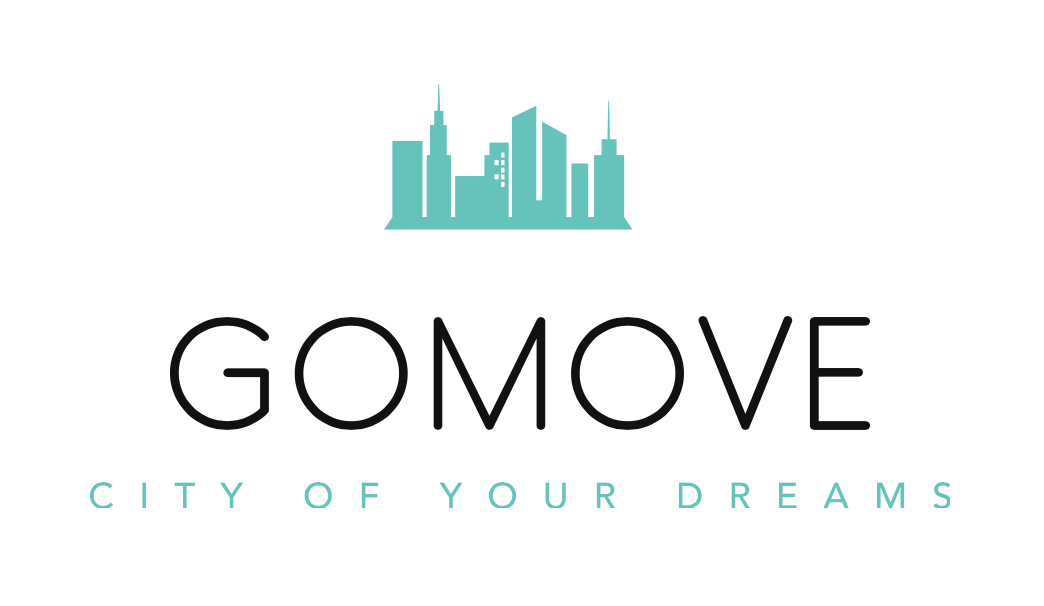

# Current Prototype

In [5]:
import pandas as pd
import numpy as np
from IPython.core.display import HTML
import folium
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import MinMaxScaler

In [6]:
anna = False
if anna == True: 
    prepath = "/Users/annagottel/Documents/Life/Techlabs/Project/Used in Code/"
else:
    prepath = ""

In [7]:
####Import and Clean Dataframe "Cost of Living"####
col = pd.read_csv(prepath+"cost-of-living-2018_index.csv")
col.drop(columns="Rank",inplace=True)
col2=col.copy()
#col2.City.isnull().sum() #->0

#Split Column with "City, Country"into 2
new_col = col2["City"].str.split(", ", n = 1, expand = True) # new data frame with split value columns 
col2["City_"]= new_col[0] # making separate first name column from new data frame 
col2["Country"]= new_col[1] # making separate last name column from new data frame 
col2.drop(columns =["City"], inplace = True) # Dropping old Name columns 

col1 = col2[ ['Country'] + [ col for col in col2.columns if col != 'Country' ] ]
col2= col1[ ['City_'] + [ col for col in col1.columns if col != 'City_' ] ]
col2.rename({'City_': 'City'}, axis=1, inplace=True)
#Save
#col2.to_csv(r'/content/drive/MyDrive/Techlabs/CostOfLiving_clean.csv',header=True)

#Clean US rows
col3=col2.copy()
new2_col = col3.Country.str.split(",", n = 1, expand = True) # new data frame with split value columns 
col3["State"]= new2_col[0] # making separate first name column from new data frame 
col3["Country_"]= new2_col[1] # making separate last name column from new data frame 
col3.drop(columns =["Country"], inplace = True) # Dropping old Name columns 

col3[["State","Country_"]]=col3[["Country_","State"]].where(col3["Country_"]==(col3.at[13,'Country_']),col3[["State","Country_"]].values) #using (col3.at[13,'Country_']) as "United States" had a spelling error that I could not find
col3.drop(columns="Country_",inplace=True)
col3.rename({'State': 'Country'}, axis=1, inplace=True)
col= col3[ ['Country'] + [ col for col in col3.columns if col != 'Country' ] ]

col_copy=col.copy()
col_copy["Country-1"]=col_copy["Country"]
col_copy[["Country"]]=col_copy[["Country-1"]].where(col_copy["Country-1"]!=(col_copy.at[13,'Country']),"United States")
col_copy.drop(columns="Country-1",inplace=True)

#Add Happiness
#Import Dataframe "Happiness Index"
happy=pd.read_csv(prepath+"World Happiness Report 2019.csv")
happy["Country or region"] = happy["Country or region"].str.replace("Bosnia and Herzegovina", "Bosnia And Herzegovina")

#Merge Dataframes
col_hap= pd.merge(col_copy,happy,how="left",left_on="Country",right_on="Country or region")
#col_hap.to_csv(r'/content/drive/MyDrive/Techlabs/COL+Happiness.csv',header=True)

####Add Population####

#improt csv and drop redundant columns
pop=pd.read_csv("worldcities.csv")
pop.drop(columns=["lat","lng","iso2","iso3","admin_name","capital","id","city"],inplace=True)

#drop empty rows and check if all rows are empty
pop.dropna(inplace=True)
#pop.isnull().sum() #check:->0,0,0

#Merge with previous dataframe ("col_hap")
col_hap_pop= pd.merge(col_hap,pop,how="left",left_on="City",right_on="city_ascii")

#Some cities exist in multiple countries, therefore only use rows where "country"(from pop dataframe) is equal to "Country" (from col_hap dataframe)
copy=col_hap_pop.copy()
col_hap_pop = copy[copy['country'] == copy['Country']]
col_hap_pop.reset_index()

#Bring "City" to front and drop redundant columns
col_hap_pop= col_hap_pop[ ['City'] + [ col for col in col_hap_pop.columns if col != 'City' ] ]#Get "City" to front
col_hap_pop.drop(columns=["Country or region","city_ascii","country"],inplace=True) #drop redundant columns

#Drop any duplicate cities (keep first/city with highest population) & reset index
col_hap_pop.drop_duplicates(["City"],inplace=True)
col_hap_pop.reset_index(inplace=True)
col_hap_pop.drop(columns="index",inplace=True)



####Add Temperature####
#Import 4th df
temp= pd.read_excel(prepath+"Average Temperature of Cities.xlsx")
#Clean temp
temp.drop(columns=["Unnamed: 0","Feb","Mar","Apr","May","Jun","Aug","Sep","Oct","Nov","Dec","Continent"],inplace=True)
temp=temp.drop_duplicates(subset='City') #Drop double-named cities
temp.City = temp.City.str.rstrip()
temp["City"] = temp["City"].str.replace("Piraeus", "Athens")
temp["City"] = temp["City"].str.replace("ó", "o")
temp["City"] = temp["City"].str.replace("ü", "u")
temp["City"] = temp["City"].str.replace("á", "a")
temp["City"] = temp["City"].str.replace("í", "i")
temp["City"] = temp["City"].str.replace("ã", "a")
temp["City"] = temp["City"].str.replace("ñ", "n")

#Merge with previous df (col_hap_pop)
df4= pd.merge(col_hap_pop,temp,how="left",left_on="City",right_on="City")

#Clean merged dataframe
df4.dropna(subset=['Jan'], inplace=True) #drop all rows that don't contain temperature data
df4.drop(columns=["Country_y","Jan","Jul"],inplace=True) #only keep yearly average temperature data
df4.rename({"Country_x":"Country","Year":"Temperature"},axis="columns",inplace=True)
df4.reset_index()

#Split Column with Temperature into 2
new_col = df4["Temperature"].str.split("(", n = 1, expand = True) # new data frame with split value columns 
df4["Temperature(°C)"]= new_col[0] # making separate first name column from new data frame 
df4["Temperature(°F)"]= new_col[1] # making separate last name column from new data frame 
df4.drop(columns =["Temperature"], inplace = True) # Dropping old Name columns 
df4["Temperature(°F)"] = df4["Temperature(°F)"].str.replace(r")", "").astype(float)
df4["Temperature(°C)"] = df4["Temperature(°C)"].str.replace(r"\n", "").astype(float)

####Add Unemployment, Education and Crime Rate####
#Import Data
UE=pd.read_csv(prepath+"unemployment_rate_by_country.csv") #unemployment rate in 5
EDU=pd.read_csv(prepath+"education_index_by_country.csv") #Education Index (0-1)
CRIME=pd.read_csv(prepath+"crime_index_by_country.csv") #Crime Index & Safety Index (0-100)

#Clean Data
UE.drop(columns=["Previous","Reference","Unit"],inplace=True)
UE.rename({"Last":"Unemployment rate"},axis="columns",inplace=True)
EDU.drop(columns=["Expected years of schooling","Mean years of schooling","HDI rank","HDI rank","Continent"], inplace=True)

#Merge the 3 dataframes
UED= pd.merge(UE,EDU,how="left",left_on="Country",right_on="Country")
EDUECR = pd.merge(UED,CRIME,how="left",left_on="Country",right_on="Country")

#Clean
EDUECR.Country = EDUECR.Country.str.rstrip()
EDUECR.Country = EDUECR.Country.str.lstrip()
EDUECR["Country"] = EDUECR["Country"].str.replace("Bosnia and Herzegovina", "Bosnia And Herzegovina")

#Merge with previous df4
df5 = pd.merge(df4,EDUECR,how="left",left_on="Country",right_on="Country")


#Clean
#Drop rows with missing values
df5.dropna(axis="rows",inplace=True)
#Drop irrelavant columns
df5.drop(columns=["Overall rank","Cost of Living Plus Rent Index","GDP per capita"],inplace=True)
#Convert Population type
df5["population"] = df5["population"].astype(int)
#Rename 
df5.rename(columns={"Score":"Happiness Score","population":"Population","Education index":"Education Index","Unemployment rate":"Unemployment rate(%)"},inplace=True)

#Add Latitude & Longtitude for map
lat = pd.read_excel(prepath+"geos.xlsx")
lat

#Merge with previous df5
df6 = pd.merge(df5,lat,how="left",left_on="City",right_on="City")
df6.drop(columns=["Country_y"],inplace=True)
df=df6.rename({"Country_x":"Country","Hours of Sun":"Hours of Sun (annually)"},axis="columns")
df

###Final Dataframe###
df

#df.to_csv(r"/content/drive/MyDrive/Techlabs/df6.csv")

,City,Country,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Happiness Score,Social support,Healthy life expectancy,...,Population,Temperature(°C),Temperature(°F),Unemployment rate(%),Education Index,Crime Index,Safety Index,Hours of Sun (annually),Latitude,Longitude
0,Zurich,Switzerland,141.25,66.14,149.86,135.76,142.70,7.480,1.526,1.052,...,434008,9.3,48.7,3.2,0.891,21.58,78.42,1566.0,47.3786,8.5400
1,Reykjavik,Iceland,123.78,57.25,118.15,133.19,88.95,7.494,1.624,1.026,...,128793,4.3,39.7,4.9,0.906,23.70,76.30,1326.0,64.1475,-21.9350
2,Oslo,Norway,117.23,49.28,112.42,124.09,102.94,7.554,1.582,1.028,...,693494,5.7,42.3,5.3,0.916,34.62,65.38,1668.0,59.9111,10.7528
3,Bergen,Norway,112.31,40.30,101.79,119.61,99.29,7.554,1.582,1.028,...,257087,7.7,45.9,5.3,0.916,34.62,65.38,1187.0,60.3925,5.3233
4,Kyoto,Japan,100.33,24.58,118.44,54.59,77.92,5.886,1.419,1.088,...,1805000,15.8,60.4,3.0,0.842,21.67,78.33,NaN,35.0111,135.7669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,Kolkata,India,27.99,7.77,28.53,23.18,56.30,4.015,0.765,0.588,...,17560000,26.7,80.1,7.0,0.624,44.42,55.58,2107.0,22.5411,88.3378
178,Karachi,Pakistan,27.10,7.46,25.60,21.62,39.06,5.653,0.886,0.535,...,14835000,26.0,78.8,4.1,0.550,44.18,55.82,2950.0,24.8600,67.0100
179,Cairo,Egypt,26.49,5.43,23.23,22.55,25.27,4.166,1.039,0.644,...,19372000,21.4,70.5,9.6,0.601,46.65,53.35,3541.0,30.0561,31.2394
180,Lviv,Ukraine,25.31,8.10,20.50,17.88,26.88,4.332,1.390,0.739,...,724314,7.8,46.0,9.9,0.803,48.84,51.16,NaN,49.8419,24.0315


In [4]:
# Map where user can hover / see the geos that are available and then select

m = folium.Map(location = [52.520008,13.404954], zoom_start=2.5)
for (index, row) in df.iterrows():
    folium.Marker(
            location = [row.loc['Latitude'], row.loc['Longitude']],
            popup = row.loc['City'] + ', ' + row.loc['Country'],
            tooltip = row.loc['City'] + ', ' + row.loc['Country'] ).add_to(m)

print("These are the cities we have available for your comparison:")
m

These are the cities we have available for your comparison:


In [8]:
#######Visualization#######

#Input City, Country

first = input("Type a city, country (without accents/umlaut): ")
# first = "Sydney, Australia"
second = input("Type another city, country for comparison (without accents/umlaut): ")
# second = "Berlin, Germany"

#Single out the two necessary rows
city_one, country_one = first.split(", ")
# city_one, country_one = city_one.strip(), country_one.strip()

city_two, country_two = second.split(", ")
# city_two, country_two = city_two.strip(), country_two.strip()

#Exclude Latitude & Longtitude
df_vis = df.drop(columns=["Latitude","Longitude"])


comp = df_vis.loc[((df_vis.City == city_one) & (df_vis.Country == country_one)) \
                | ((df_vis.City == city_two) & (df_vis.Country == country_two))].reset_index().drop(columns=["index"])

comp_up = comp.melt(id_vars=['City','Country'], var_name='Attribute', value_name='Index')

comp_up["city_country"] = comp_up["City"] + ", " + comp_up["Country"]

comp_chart = comp_up.pivot(index='Attribute',columns='city_country',values='Index').rename_axis(None, axis=1)
comp_chart.dropna(inplace=True)
chart = comp_chart.copy()
comp_chart = comp_chart.drop(["Population","Temperature(°C)","Temperature(°F)"])
comp_web = comp_chart.copy()

####Print basic facts####
print_chart=chart.drop(["Generosity","Cost of Living Index","Rent Index","Groceries Index","Restaurant Price Index","Local Purchasing Power Index","Education Index","Safety Index","Social support","Healthy life expectancy","Freedom to make life choices","Perceptions of corruption","Crime Index","Temperature(°C)","Temperature(°F)"])
#print_chart=print_chart.astype(float)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("Great choices! Here are some basic facts about your cities of choice:")
display(print_chart)
print("_______________________________________")
print("")


####Print temperature + graph of sun or snow####
temp_chart=chart.drop(["Happiness Score","Generosity","Cost of Living Index","Rent Index","Groceries Index","Restaurant Price Index","Local Purchasing Power Index","Unemployment rate(%)","Education Index","Safety Index","Social support","Healthy life expectancy","Freedom to make life choices","Perceptions of corruption","Crime Index","Population",])

#Create duplicate of first row
temp_chart=temp_chart.append(temp_chart)
temp_chart.index = temp_chart.index.where(~temp_chart.index.duplicated(), temp_chart.index + '_')
temp_chart.rename({"Temperature(°C)_":"Climate"},inplace=True)
temp_chart.drop(["Temperature(°F)_","Hours of Sun (annually)_"],inplace=True)
temp_chart=temp_chart.astype(float)

#Create visualized comparison 
non_index = ["Temperature(°C)","Temperature(°F)","Hours of Sun (annually)"]

#visualise first column
for i, row in temp_chart.iterrows():
    if i not in non_index:
        if row[first] > df4["Temperature(°C)"].mean():
            temp_chart.loc[i,first] = 'https://png.pngtree.com/png-vector/20190629/ourmid/pngtree-sun-icon-design-png-image_1518941.jpg'
        elif row[first] > 10:
            temp_chart.loc[i,first] = 'https://www.arartur.com.tr/images/content/1619327878.png'
        else: 
            temp_chart.loc[i,first] = 'https://www.freeiconspng.com/thumbs/snow-icon/blue-snow-icon-8.png' 

#visualize second column
for i, row in temp_chart.iterrows():
    if i not in non_index:
        if  row[second] > df4["Temperature(°C)"].mean():
            temp_chart.loc[i,second] = 'https://png.pngtree.com/png-vector/20190629/ourmid/pngtree-sun-icon-design-png-image_1518941.jpg'
        elif row[second] > 10:
            temp_chart.loc[i,second] = 'https://www.arartur.com.tr/images/content/1619327878.png'
        else: 
            temp_chart.loc[i,second] = 'https://www.freeiconspng.com/thumbs/snow-icon/blue-snow-icon-8.png'

def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'

temp_chart[first] = temp_chart[first].apply(lambda x: '<img src="' + x + '" width="60" >' if "http" in str(x) else x)
temp_chart[second] = temp_chart[second].apply(lambda x: '<img src="' + x + '" width="60" >' if "http" in str(x) else x)

print("In terms of the local climate, this is the average yearly temperature that you can expect for each city:")
display(HTML(temp_chart.to_html(escape=False)))
print("_______________________________________")
print("")

####Create visualized comparison of Attributes####
non_index = ["Temperature(°C)","Temperature(°F)","Population"]
bad = ["Crime Index", "Unemployment rate(%)", "Perceptions of corruption","Cost of Living Index","Rent Index","Groceries Index","Restaurant Price Index"]

for i, row in comp_chart.iterrows():
    if i not in non_index:
        if i in bad:
            if row[first] > row[second]:
                comp_chart.loc[i,first] = 'https://upload.wikimedia.org/wikipedia/commons/5/5f/Red_X.svg'
                comp_chart.loc[i,second] = 'https://upload.wikimedia.org/wikipedia/commons/b/b0/Light_green_check.svg'
            else: 
                comp_chart.loc[i,first] = 'https://upload.wikimedia.org/wikipedia/commons/b/b0/Light_green_check.svg'
                comp_chart.loc[i,second] = 'https://upload.wikimedia.org/wikipedia/commons/5/5f/Red_X.svg'
        else:
            if row[first] > row[second]:
                comp_chart.loc[i,first] = 'https://upload.wikimedia.org/wikipedia/commons/b/b0/Light_green_check.svg'
                comp_chart.loc[i,second] = 'https://upload.wikimedia.org/wikipedia/commons/5/5f/Red_X.svg'
            else: 
                comp_chart.loc[i,first] = 'https://upload.wikimedia.org/wikipedia/commons/5/5f/Red_X.svg'
                comp_chart.loc[i,second] = 'https://upload.wikimedia.org/wikipedia/commons/b/b0/Light_green_check.svg'

def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'

comp_chart[first] = comp_chart[first].apply(lambda x: '<img src="' + x + '" width="60" >' if "http" in str(x) else x)
comp_chart[second] = comp_chart[second].apply(lambda x: '<img src="' + x + '" width="60" >' if "http" in str(x) else x)

print("We have also compared the two locations for you. The following graphic shows the winnig city for each attribute:")

print("(Lower values win for: Crime Index, Unemployment rate(%), Perceptions of corruption, Cost of Living Index, Rent Index, Groceries Index & Restaurant Price Index)")
print("(Higher values win for: Happiness Score, Generosity, Local Purchasing Power Index, Education Index, Safety Index, Social support, Healthy life expectancy & Freedom to make life choices)")

display(HTML(comp_chart.to_html(escape=False)))

Type a city, country (without accents/umlaut): Berlin, Germany
Type another city, country for comparison (without accents/umlaut): Sydney, Australia
Great choices! Here are some basic facts about your cities of choice:


,"Berlin, Germany","Sydney, Australia"
Attribute,,
Happiness Score,6.99,7.23
Hours of Sun (annually),1626.00,2635.00
Population,3644826.00,5312163.00
Unemployment rate(%),4.50,6.90


_______________________________________

In terms of the local climate, this is the average yearly temperature that you can expect for each city:


,"Berlin, Germany","Sydney, Australia"
Attribute,,
Hours of Sun (annually),1626.00,2635.00
Temperature(°C),10.30,17.70
Temperature(°F),50.50,63.90
Climate,,


_______________________________________

We have also compared the two locations for you. The following graphic shows the winnig city for each attribute:
(Lower values win for: Crime Index, Unemployment rate(%), Perceptions of corruption, Cost of Living Index, Rent Index, Groceries Index & Restaurant Price Index)
(Higher values win for: Happiness Score, Generosity, Local Purchasing Power Index, Education Index, Safety Index, Social support, Healthy life expectancy & Freedom to make life choices)


,"Berlin, Germany","Sydney, Australia"
Attribute,,
Cost of Living Index,,
Crime Index,,
Education Index,,
Freedom to make life choices,,
Generosity,,
Groceries Index,,
Happiness Score,,
Healthy life expectancy,,
Hours of Sun (annually),,


In [9]:
scaler = MinMaxScaler()
df_norm = df_vis.copy()
df_norm.iloc[:,2:] = scaler.fit_transform(df_norm.iloc[:,2:])
# display(df_norm)

In [10]:
comp_norm = df_norm.loc[((df_norm.City == city_one) & (df_norm.Country == country_one)) \
        | ((df_norm.City == city_two) & (df_norm.Country == country_two))].reset_index().drop(columns=["index"])

comp_norm_up = comp_norm.melt(id_vars=['City','Country'], var_name='Attribute', value_name='Index')

comp_norm_up["city_country"] = comp_norm_up["City"] + ", " + comp_norm_up["Country"]

comp_norm_chart = comp_norm_up.pivot(index='Attribute',columns='city_country',values='Index').rename_axis(None, axis=1)
comp_norm_chart.dropna(inplace=True)
comp_web = comp_norm_chart.copy()

In [11]:
comp_norm["Location"] = comp_norm["City"] + ", " + comp_norm["Country"]
comp_norm.drop(columns=["City","Country"],inplace=True)
print("These are the factors from which you can choose and make your location preference: ")
print(list(comp_norm.columns)[:-1])

These are the factors from which you can choose and make your location preference: 
['Cost of Living Index', 'Rent Index', 'Groceries Index', 'Restaurant Price Index', 'Local Purchasing Power Index', 'Happiness Score', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Population', 'Temperature(°C)', 'Temperature(°F)', 'Unemployment rate(%)', 'Education Index', 'Crime Index', 'Safety Index', 'Hours of Sun (annually)']


In [12]:
user_input = int(input("How many location factors are your considering? "))
fact_count = user_input
factor_list = []
while user_input != "done":
    user_input = input("What are some of the location factors you are considering (or enter 'done')? ")
    factor_list.append(user_input)
factor_list.remove("done")
factor_list.insert(0,"Location")

How many location factors are your considering? 3
What are some of the location factors you are considering (or enter 'done')? Safety Index
What are some of the location factors you are considering (or enter 'done')? Education Index
What are some of the location factors you are considering (or enter 'done')? Generosity
What are some of the location factors you are considering (or enter 'done')? done


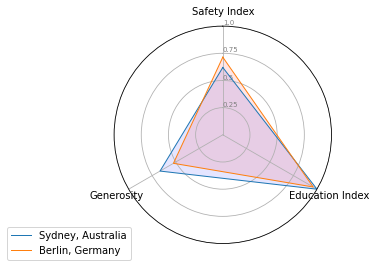

In [13]:
# ------- PART 1: Create background

# number of variable
categories = factor_list[1:]
N = fact_count

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75,1.0], ["0.25","0.5","0.75","1.0"], color="grey", size=7)
plt.ylim(0,1)


# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable

comp_web = comp_norm[factor_list]

# Ind1
values = comp_web.loc[0].drop('Location').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=comp_web.loc[0][0])
ax.fill(angles, values, 'b', alpha=0.1)

# Ind2
values = comp_web.loc[1].drop('Location').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=comp_web.loc[1][0])
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

# Feedback and Future

In [14]:
user_feedback = input("We are curious about your feedback.\nWhat other cities or factors are we missing and would be useful? ")

We are curious about your feedback.
What other cities or factors are we missing and would be useful? more cities


Future work:

-notes about error handling

-weighting/prioritizing factors for location preference

-fun facts about and pictures of the city